In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0, state = None):
        outputs = []
        #print(input.shape)
        #print(input.size(0))
        #if state is None:
        if True:
            h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
            c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
            h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
            c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        else: 
            h_t, c_t, h_t2, c_t2 = state[0], state[1], state[2], state[3]
        #print(input.shape) # (1, 999)
        '''for input_t in input[0]:
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]'''
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            #print('input_t: ', input_t.shape)
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            #print('h_t: ', h_t.shape)
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            #print(output.shape)
            outputs += [output]
        #print('input: ', input.shape)
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            #print(output.shape)
            outputs += [output]
        #print(outputs.shape)
        outputs = torch.stack(outputs, 1).squeeze(2)
        #print(outputs.shape)
        h_state = [h_t, c_t, h_t2, c_t2]
        return outputs, h_state

In [123]:
class LSTM_RNN(nn.Module):
    def __init__(self):
        super(LSTM_RNN, self).__init__()
        self.hidden_size = 51
        self.batch_size = 1
        self.num_layer = 1
        self.in_size = 20
        self.out_size = 20
        IN_DIM = 2
        
        # Input shape:  torch.Size([1, 1, 2])
        # Input shape:  torch.Size([6, 1, 2])
        self.hidden = self.init_hidden()
        self.lstm = nn.LSTM(IN_DIM, self.hidden_size) # IN_DIM, OUT_DIM
        self.linear1 = nn.Linear(20, 100)
        self.linear2 = nn.Linear(20, 100)
        self.linear3 = nn.Linear(200, 50)
        self.linear_x = nn.Linear(50, self.out_size)
        self.linear_y = nn.Linear(50, self.out_size)

    def forward(self, input_x, input_y):        
        '''out, self.hidden = self.lstm(input, self.hidden)
        d_len = int(len(input)/2)
        for i in range(d_len):
            data = input[i:i+d_len]'''
        in_x = self.linear1(input_x)
        in_y = self.linear2(input_y)
        #print(in_x.shape, in_y.shape)
        fc1 = torch.cat((in_x, in_y), dim=0)
        print(fc1.shape)
        fc2 = self.linear3(fc1)
        x = self.linear_x(fc2)
        y = self.linear_y(fc2)
        return [x, y]
    
    def init_hidden(self):
        hidden = (torch.randn(self.num_layer, self.batch_size, self.hidden_size), \
                  torch.randn(self.num_layer, self.batch_size, self.hidden_size))
        return hidden
# build the model
seq = LSTM_RNN()
#seq.load_state_dict(torch.load('seq.pth'))
seq.float()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
#optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
optimizer = torch.optim.Adam(seq.parameters(), lr=0.005)
#begin to train
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

In [93]:
# build the model
seq = Sequence()
#seq.load_state_dict(torch.load('seq.pth'))
seq.double()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
#optimizer = torch.optim.Adam(seq.parameters(), lr=0.005)
#begin to train
old_state = None
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

In [112]:
# build the model
seq = LSTM_RNN()
#seq.load_state_dict(torch.load('seq.pth'))
seq.float()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
#optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
optimizer = torch.optim.Adam(seq.parameters(), lr=0.005)
#begin to train
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

In [47]:
def create_sin_pt():
    # load data and make training set
    data = torch.load('traindata.pt')
    data = data[0][:]
    data = np.expand_dims(data, axis=0)
    print(data.shape)
    input = torch.from_numpy(data[:, :-1])
    #print(input.shape)
    target = torch.from_numpy(data[:, 1:])
    test_input = torch.from_numpy(data[:, :-1])
    print('test_input: ', test_input.shape)
    test_target = torch.from_numpy(data[:, 1:])
    return data, input, target, test_input, test_target

In [32]:
def create_linear():
    step = 5
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(0, 100, 1000, dtype=np.double)
    #x_np = np.sin(steps)    # float32 for converting torch FloatTensor
    x_np = steps
    data = np.expand_dims(x_np, axis=0)
    input = torch.from_numpy(data[:, :-1])
    #print(input.shape)
    target = torch.from_numpy(data[:, 1:])
    test_input = torch.from_numpy(data[:, :-1])
    test_target = torch.from_numpy(data[:, 1:])
    print('test_input: ', test_input.shape)
    plt.plot(steps, x_np, 'b-', label='input (sin)')
    plt.legend(loc='best')
    plt.show()
    return data, input, target, test_input, test_target

In [33]:
def create_sin():
    step = 5
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(0, 100, 1000, dtype=np.double)
    x_np = np.sin(steps)    # float32 for converting torch FloatTensor
    #x_np = steps
    data = np.expand_dims(x_np, axis=0)
    input = torch.from_numpy(data[:, :-1])
    #print(input.shape)
    target = torch.from_numpy(data[:, 1:])
    test_input = torch.from_numpy(data[:, :-1])
    test_target = torch.from_numpy(data[:, 1:])
    print('test_input: ', test_input.shape)
    plt.plot(steps, x_np, 'b-', label='input (sin)')
    plt.legend(loc='best')
    plt.show()
    return data, input, target, test_input, test_target

test_input:  torch.Size([1, 999])


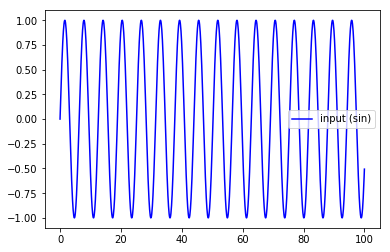

In [36]:
#data, input, target, test_input, test_target = create_sin_pt()
#data, input, target, test_input, test_target = create_linear()
data, input, target, test_input, test_target = create_sin()

In [14]:
#print(data.shape)
print(input.shape)
print(target.shape)
print(test_input.shape)
print(test_target.shape)

torch.Size([20, 2])
torch.Size([20, 2])
torch.Size([20, 2])
torch.Size([20, 2])


In [104]:
input_x = []
input_y = []
for i in positions[0:20]:
    input_x.append(i[0])
    input_y.append(i[1])
input_x = torch.tensor(input_x)
input_y = torch.tensor(input_y)
print(input_x.shape)

torch.Size([20])


Number of position:  80
torch.Size([20])


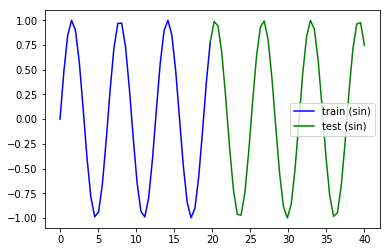

In [121]:
X_LEN = 40
P_NUM = 80
# (x, y, z) ==> (x~y)/z
x_np = np.linspace(0, X_LEN, P_NUM, dtype=np.double)
y_np = np.linspace(0, X_LEN, P_NUM, dtype=np.double)
y_np = np.sin(y_np)    # float32 for converting torch FloatTensor
positions = []
for i in range(P_NUM):
    noise = np.random.rand(1, 1)[0][0]/2.
    positions.append([x_np[i], y_np[i]])
print('Number of position: ', len(positions))


input_x = []
input_y = []
for i in positions[0:20]:
    input_x.append(i[0])
    input_y.append(i[1])
input_x = torch.tensor(input_x)
input_y = torch.tensor(input_y)

target_x = []
target_y = []
for i in positions[20:40]:
    target_x.append(i[0])
    target_y.append(i[1])
target_x = torch.tensor(target_x)
target_y = torch.tensor(target_y)

test_input_x = []
test_input_y = []
for i in positions[40:60]:
    test_input_x.append(i[0])
    test_input_y.append(i[1])
test_input_x = torch.tensor(input_x)
test_input_y = torch.tensor(input_y)

test_target_x = []
test_target_y = []
for i in positions[60:80]:
    test_target_x.append(i[0])
    test_target_y.append(i[1])
test_target_x = torch.tensor(test_target_x)
test_target_y = torch.tensor(test_target_y)

#input = torch.tensor(positions[0:20]).double()
#target = torch.tensor(positions[20:40]).double()
#test_input = torch.tensor(positions[40:60]).double()
#test_target = torch.tensor(positions[60:80]).double()

p_x = []
p_y = []
for i in positions:
    p_x.append(i[0])
    p_y.append(i[1])
print(input_x.shape)
plt.plot(p_x[:40], p_y[:40], 'b-', label='train (sin)')
plt.plot(p_x[39:], p_y[39:], 'g-', label='test (sin)')

plt.legend(loc='best')
plt.show()

In [125]:
def show_model():
    with torch.no_grad():
        #if True:
        future = 30
        predict_pos = seq(input_x, input_y)
        print(predict_pos)
        #loss = criterion(predict_pos, target)
        #print('test loss:', loss.item())
        #y = pred.cpu().detach().numpy()
        #test_input_draw = test_input.cpu().numpy()
    # draw the result
    '''plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    def new_draw(yi, color, shape):
        if shape == 1:
            plt.plot(np.arange(len(yi)), yi[:len(yi)], color, linewidth = 2.0)
        elif shape == 2:
            plt.plot(np.arange(len(yi)), yi[:len(yi)], color + ':', linewidth = 2.0)
    #print(len(y[0]), test_input_draw[0].shape)
    new_draw(y[0], 'r', 1)
    new_draw(test_input_draw[0], 'g', 2)
    #plt.close()'''
show_model()

torch.Size([200])
[tensor([ 0.5031, -0.7837, -0.9371,  1.4794, -1.0732, -0.4208, -0.5750, -0.5677,
        -0.3535, -1.2171, -1.5817,  0.2765,  0.7568, -1.3623, -1.3073, -1.7192,
         1.4274, -0.7640, -1.1393, -1.6452]), tensor([-0.1011,  0.9523, -0.8808, -1.0200,  1.2974, -2.4577,  2.5761, -1.9926,
        -1.1599,  0.2440, -1.0066,  1.9940, -0.7410, -0.7797,  1.2198,  0.7300,
        -0.6373,  0.6841, -0.1900,  0.9387])]


In [96]:
def show_model_lstm():
    with torch.no_grad():
        #if True:
        future = 30
        pred, h_state = seq(test_input, future=future, state = old_state)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())
        y = pred.cpu().detach().numpy()
        test_input_draw = test_input.cpu().numpy()
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    def new_draw(yi, color, shape):
        if shape == 1:
            plt.plot(np.arange(len(yi)), yi[:len(yi)], color, linewidth = 2.0)
        elif shape == 2:
            plt.plot(np.arange(len(yi)), yi[:len(yi)], color + ':', linewidth = 2.0)
    #print(len(y[0]), test_input_draw[0].shape)
    new_draw(y[0], 'r', 1)
    new_draw(test_input_draw[0], 'g', 2)
    #plt.close()

In [49]:
EPOCH = 5
for i in range(EPOCH):
    print('Epoch: ', i)
    seq
    loss = criterion(out, target) 
    optimizer.zero_grad()
    loss.backward()

Epoch:  0


NameError: name 'out' is not defined

In [56]:
for i in range(10):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out, h_state = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    '''out, h_state = seq(input, state = old_state)
    loss = criterion(out, target)         # cross entropy loss
    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()'''
    h_0 = Variable(h_state[0].data)
    h_1 = Variable(h_state[1].data)
    h_2 = Variable(h_state[2].data)
    h_3 = Variable(h_state[3].data)
    #old_state = [h_0, h_1]
    old_state = [h_0, h_1, h_2, h_3]
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 1000
        pred, h_state = seq(test_input, future=future, state = old_state)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())
        y = pred.cpu().detach().numpy()
        test_input_draw = test_input.cpu().numpy()
        #print('test_input_draw: ', test_input_draw.shape)
        #print('Prediction shape: ', y.shape)
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    def new_draw(yi, color, shape):
        if shape == 1:
            plt.plot(np.arange(len(yi)), yi[:len(yi)], color, linewidth = 2.0)
        elif shape == 2:
            plt.plot(np.arange(len(yi)), yi[:len(yi)], color + ':', linewidth = 2.0)
    #print(len(y[0]), test_input_draw[0].shape)
    new_draw(y[0], 'r', 1)
    new_draw(test_input_draw[0], 'g', 2)
    #draw(y[2], 'b')
    #plt.savefig('predict%d.pdf'%i)
plt.close()

STEP:  0
torch.Size([1, 51])
loss: 0.5046604438390492
torch.Size([1, 51])
loss: 0.5008928058667892
torch.Size([1, 51])
loss: 0.4846488284167046
torch.Size([1, 51])
loss: 0.45884636094312375
torch.Size([1, 51])
loss: 0.3480862216277208
torch.Size([1, 51])
loss: 0.46710744043742003


KeyboardInterrupt: 

In [55]:
torch.save(seq.state_dict(), 'seq.pth')

test_input:  torch.Size([1, 999])
STEP:  0
test loss: 0.4175188227838614
STEP:  1
test loss: 0.18071860451227187
STEP:  2
test loss: 1.2427992551346179
STEP:  3
test loss: 0.08083736404591924
STEP:  4
test loss: 0.09197711477102964
STEP:  5
test loss: 0.14676616878244483
STEP:  6
test loss: 0.15357129895587887
STEP:  7
test loss: 0.13285722529867752
STEP:  8
test loss: 0.10966994337674088
STEP:  9
test loss: 0.08284152181410534
STEP:  10
test loss: 0.06022735427387552
STEP:  11
test loss: 0.04536882472805124
STEP:  12
test loss: 0.04124865367556958
STEP:  13
test loss: 0.04914585378070306
STEP:  14
test loss: 0.0454782630881123
STEP:  15
test loss: 0.03306508616100445
STEP:  16
test loss: 0.02300926981775403
STEP:  17
test loss: 0.02037669463119747
STEP:  18
test loss: 0.019551886322641463
STEP:  19
test loss: 0.01923230094193119
STEP:  20
test loss: 0.017339861263734376
STEP:  21


C:\Users\championway\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


test loss: 0.014345353264789643
STEP:  22
test loss: 0.010398727743255063
STEP:  23
test loss: 0.007191753807886722
STEP:  24
test loss: 0.004771741960509448
STEP:  25


KeyboardInterrupt: 

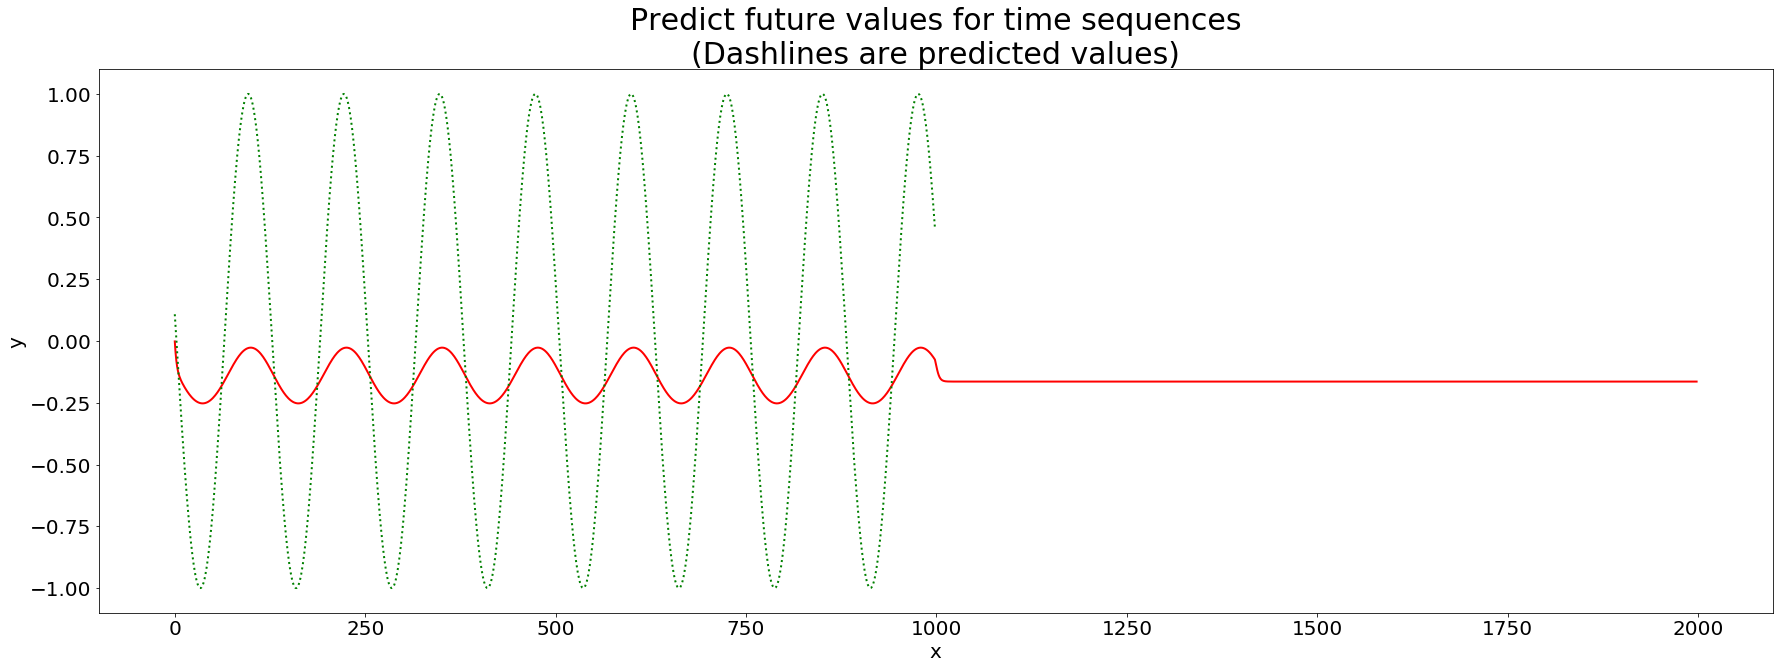

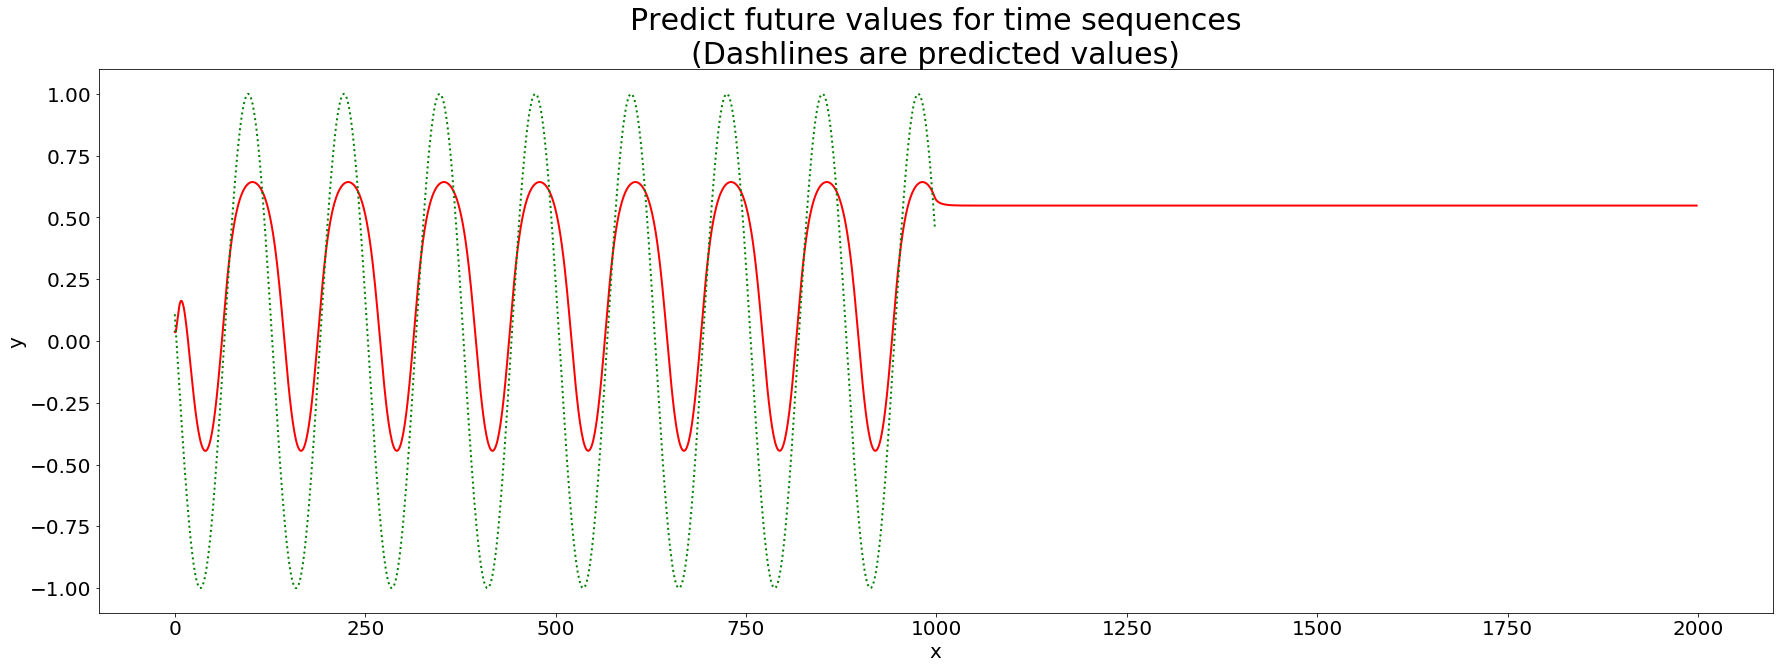

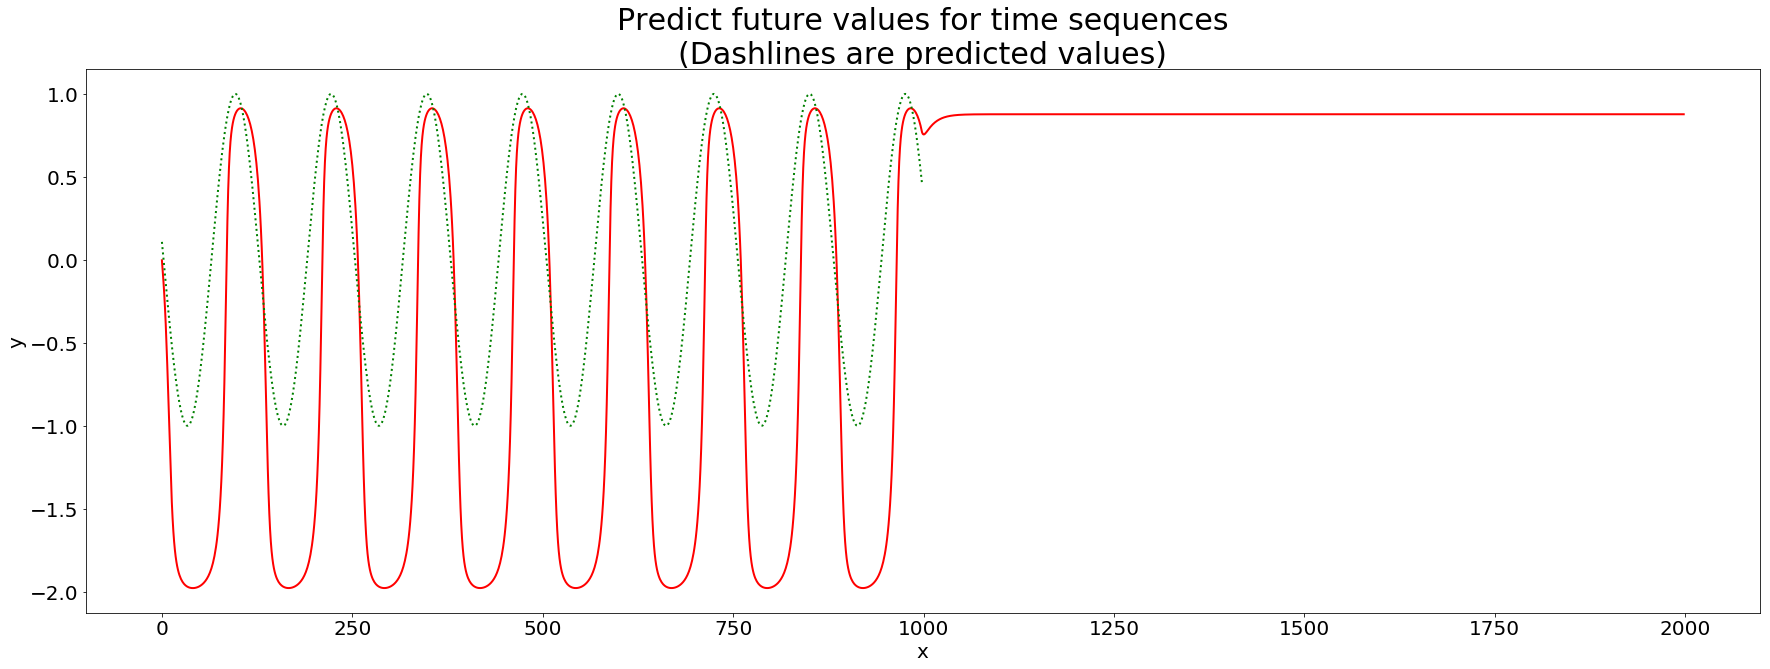

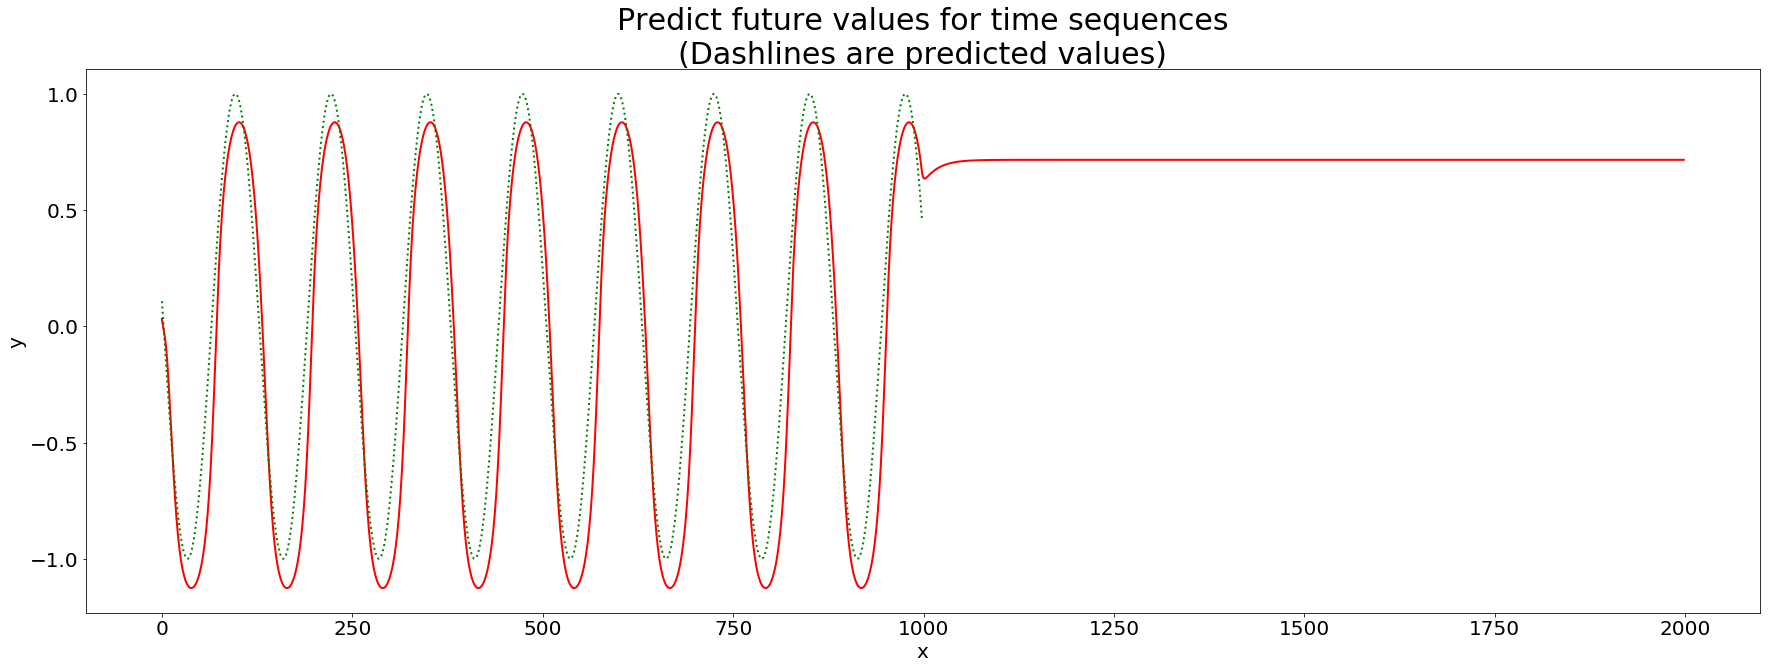

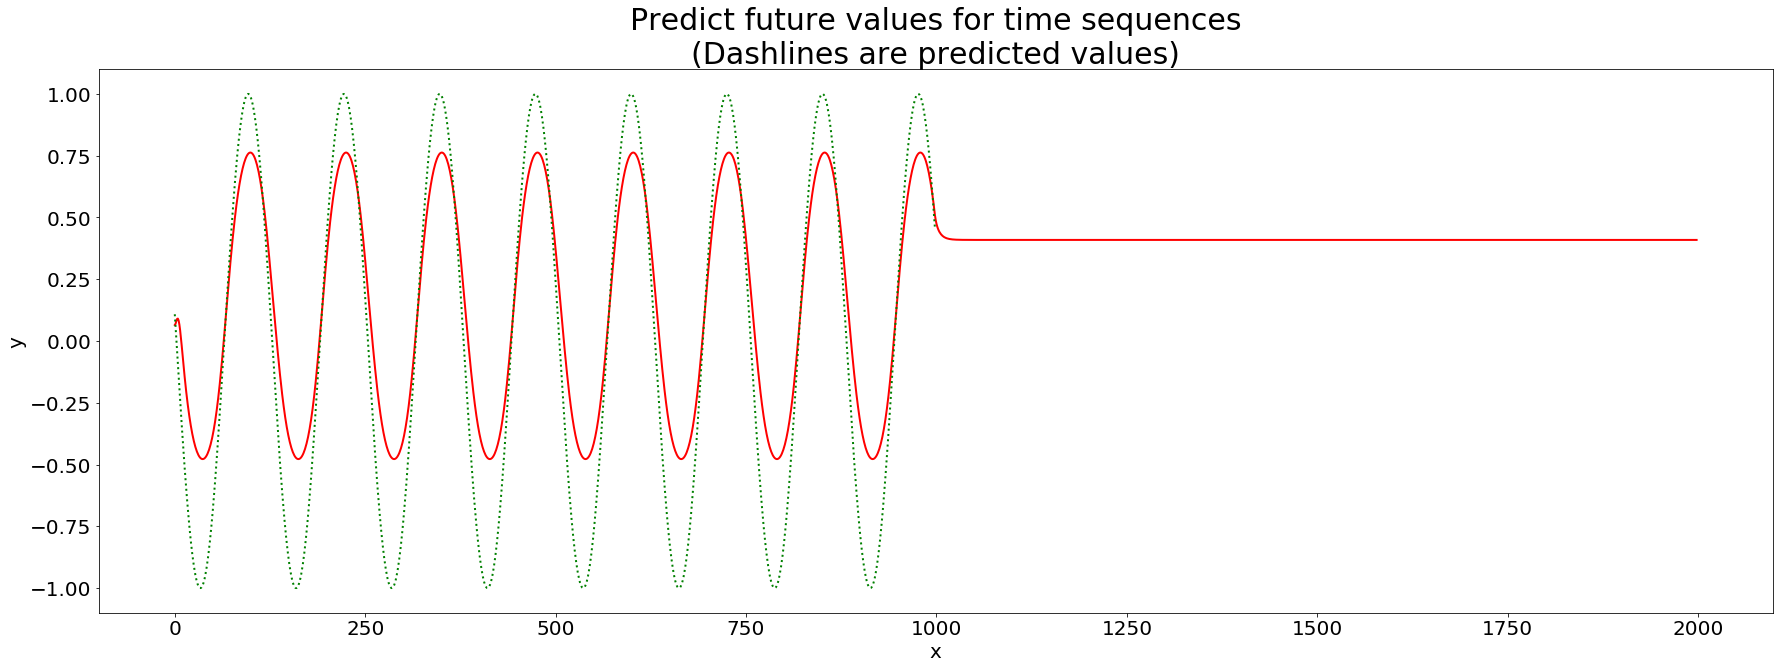

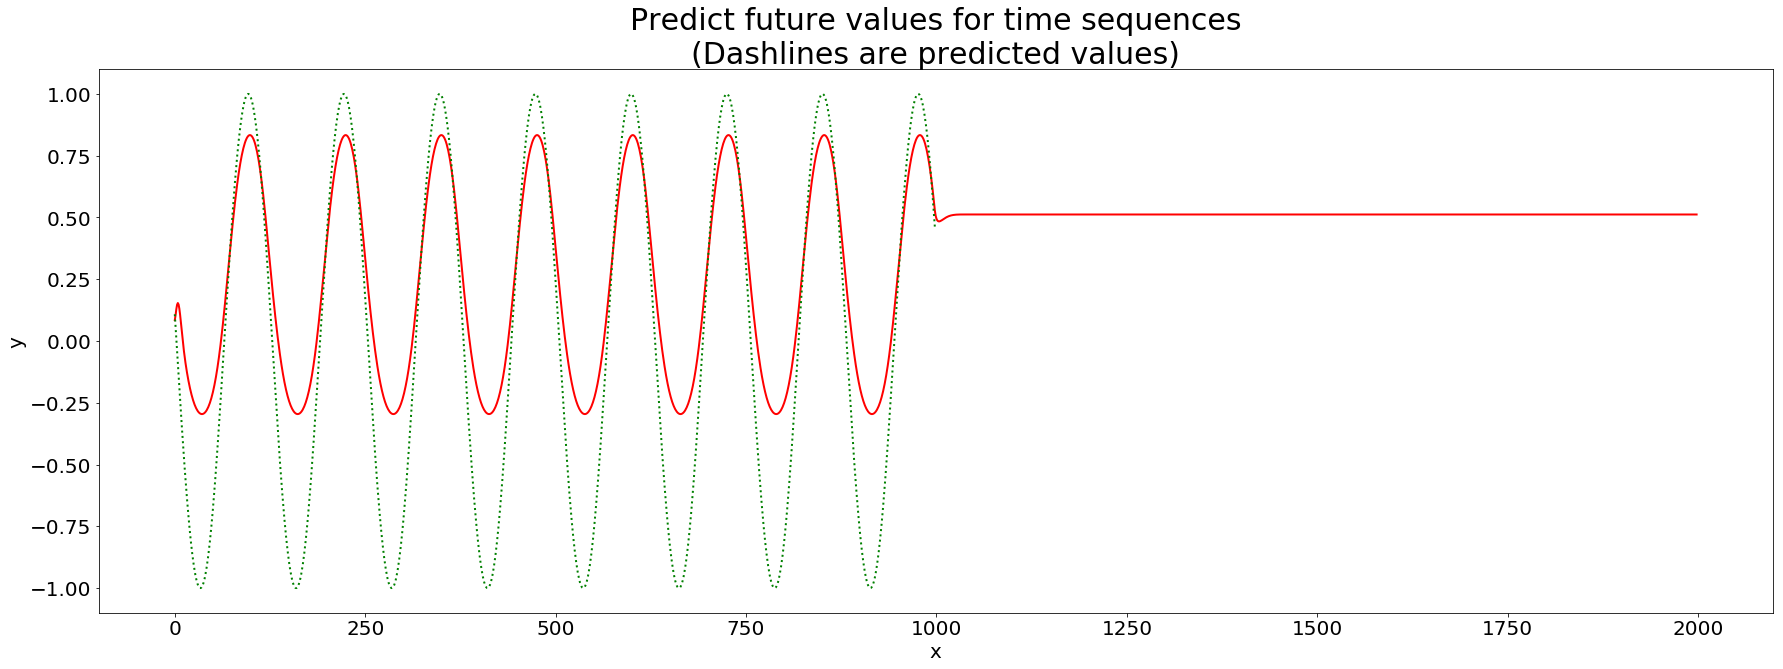

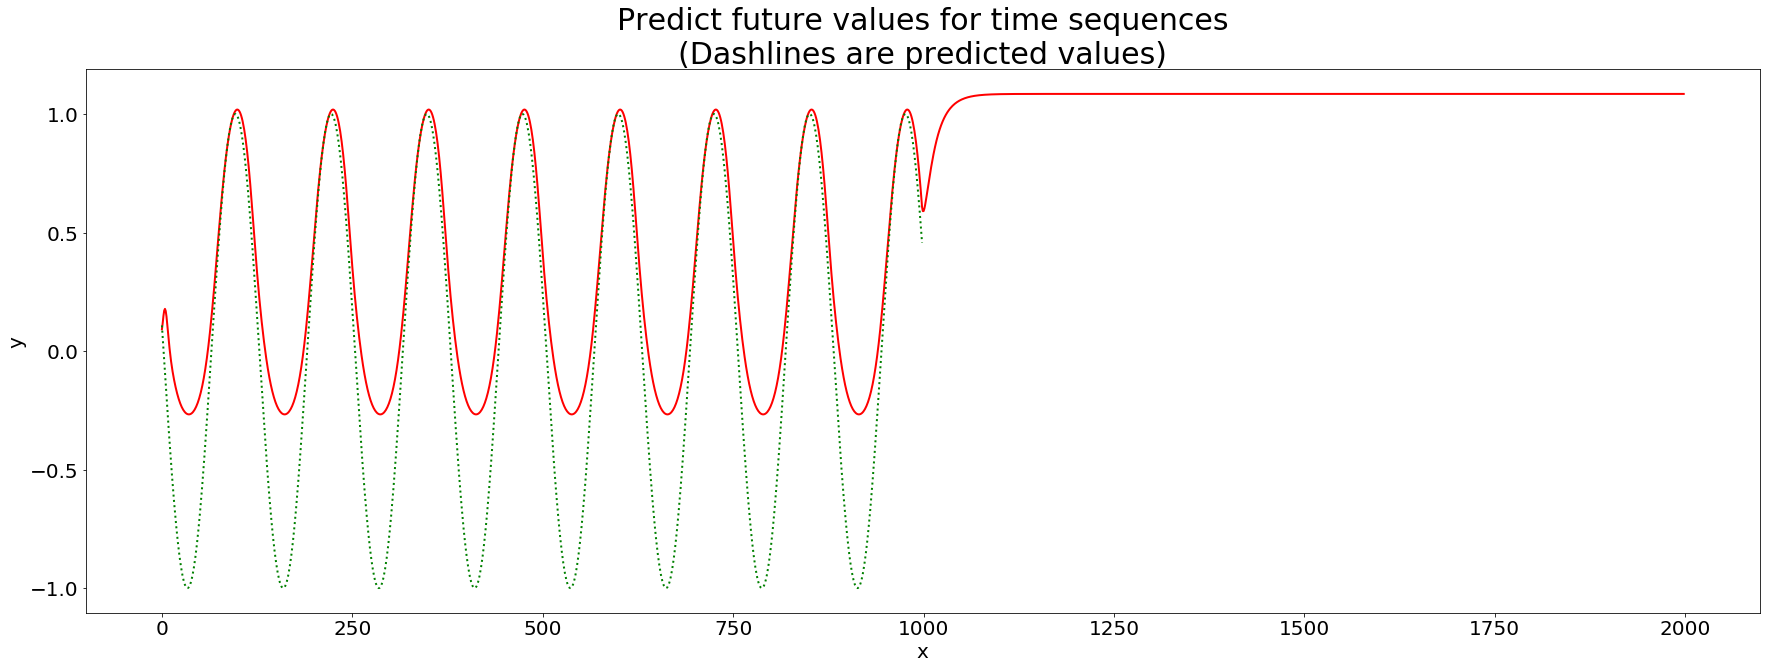

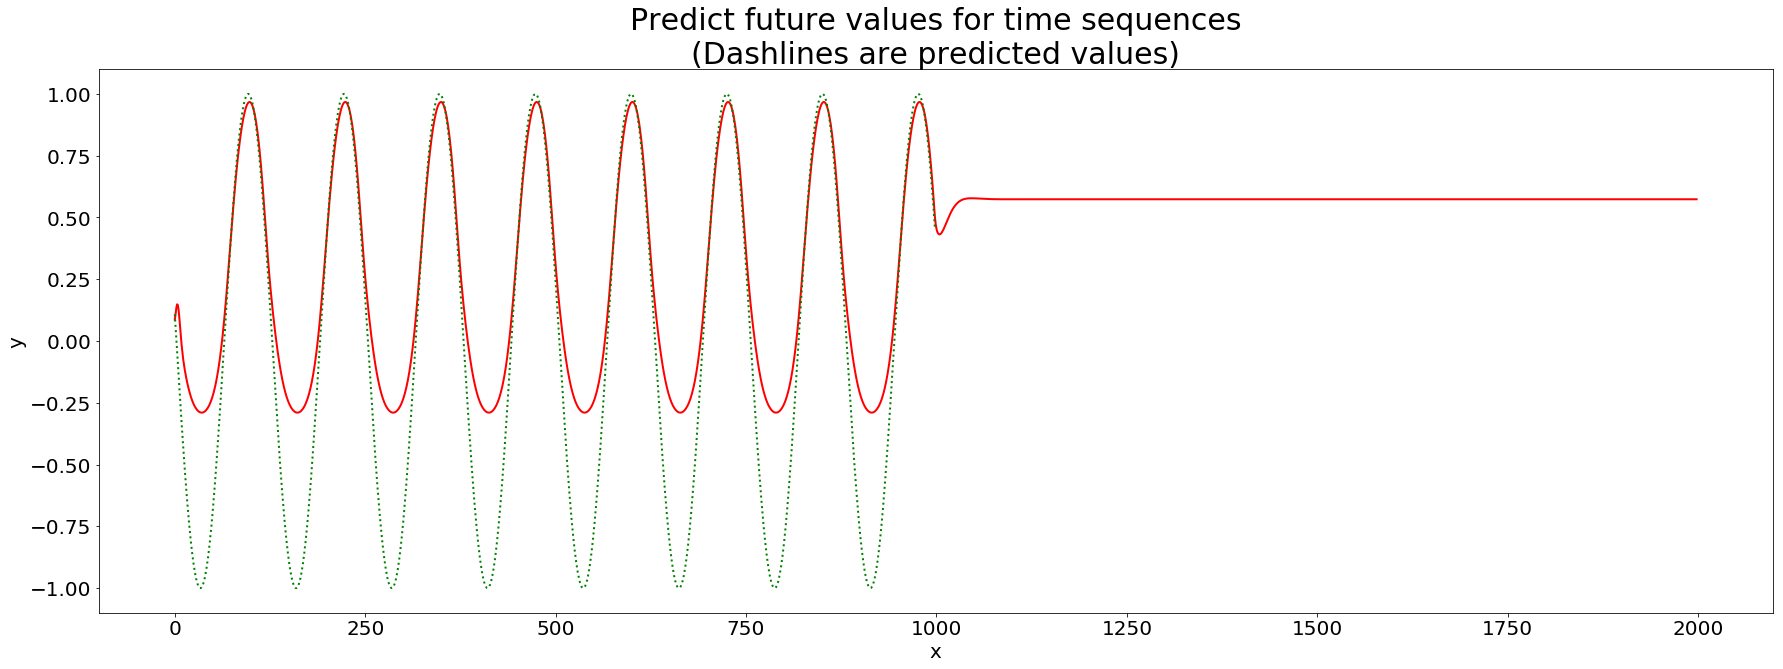

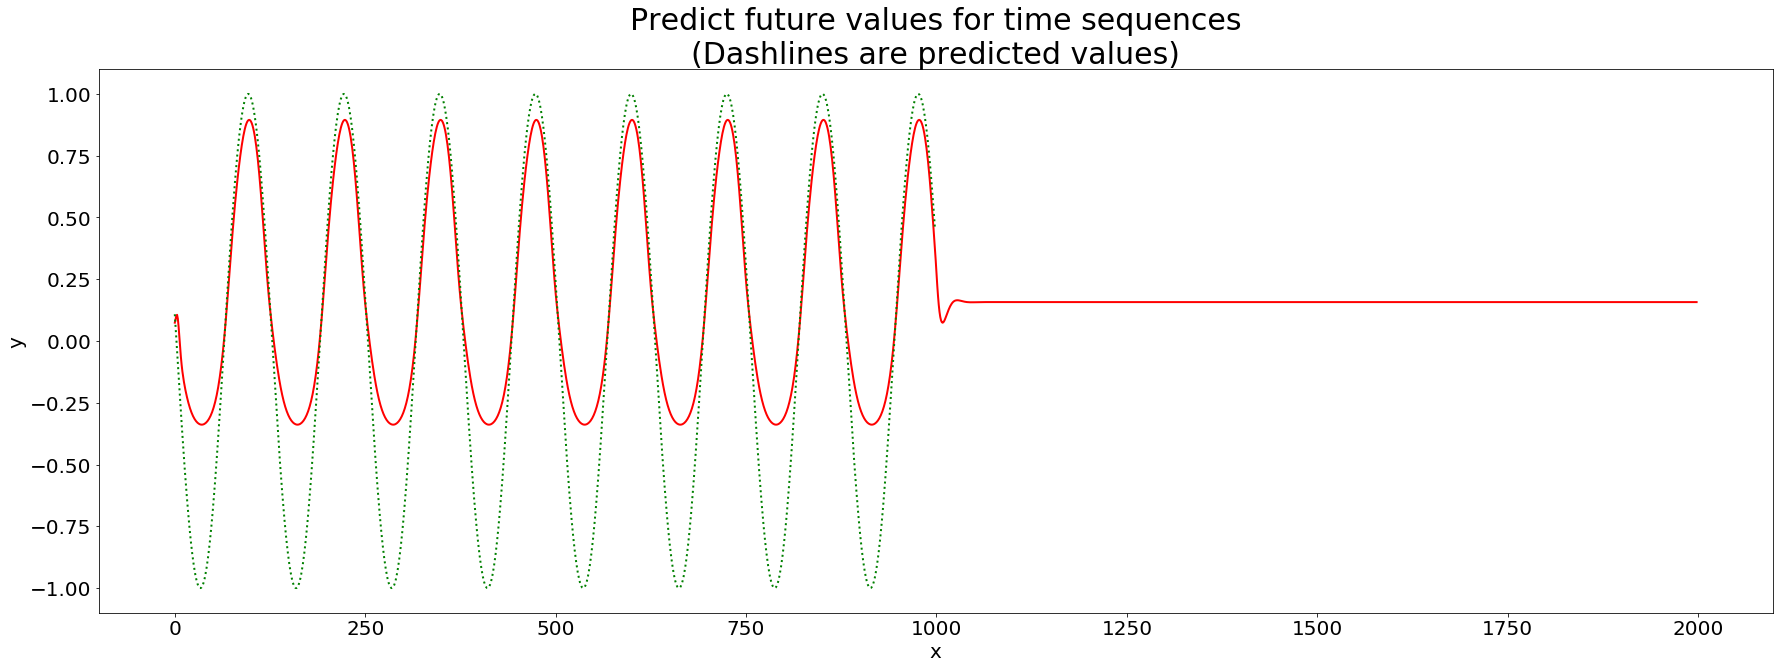

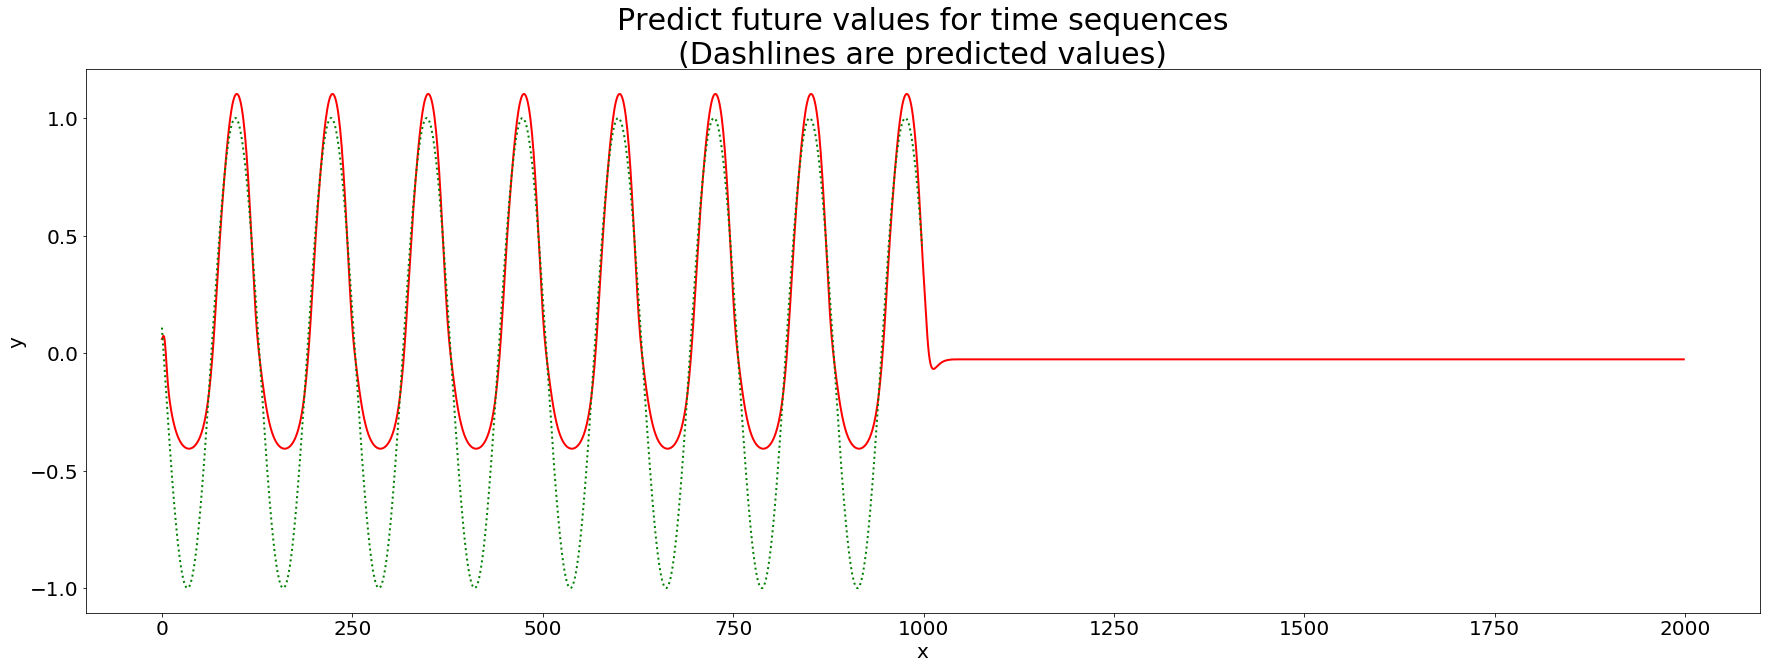

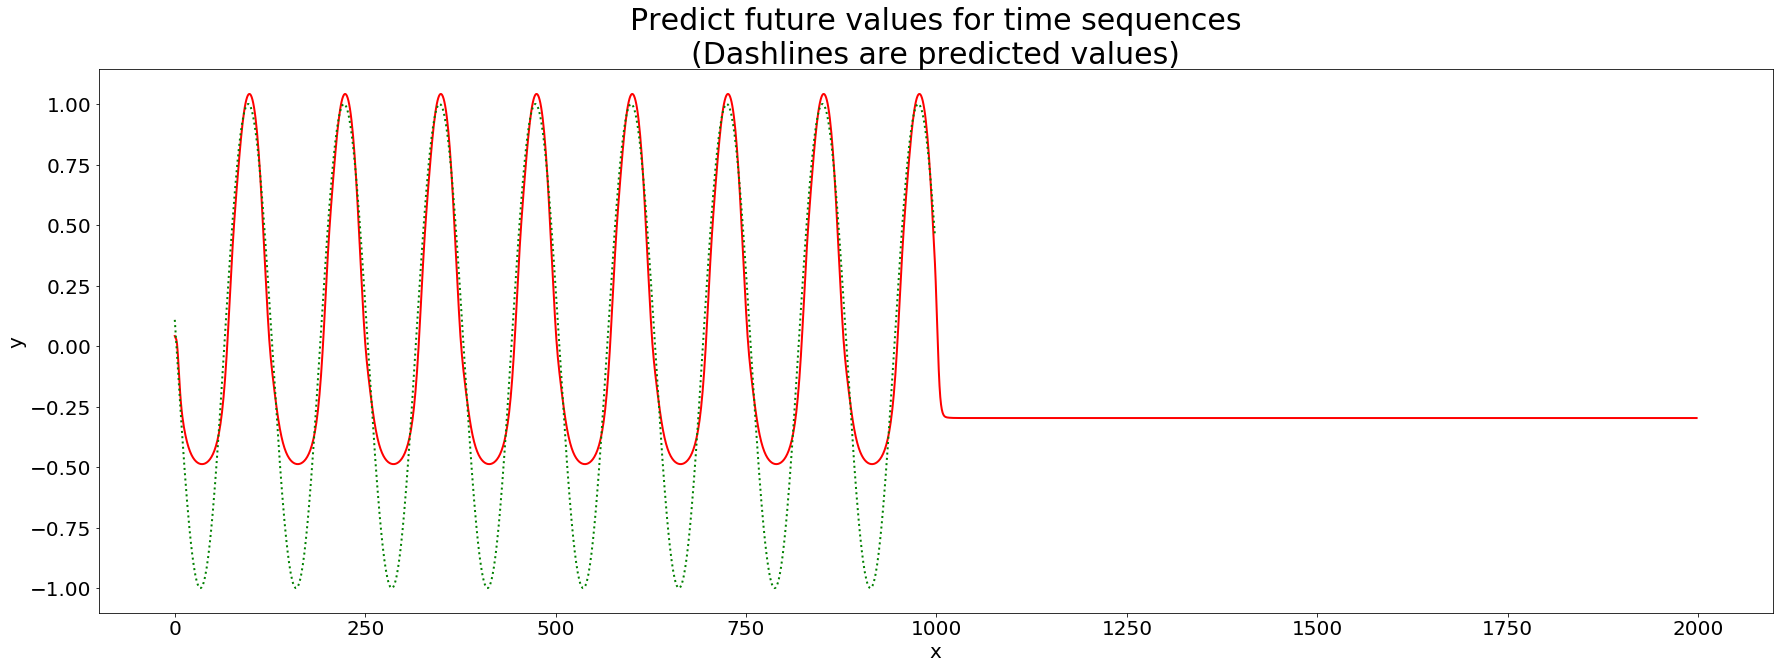

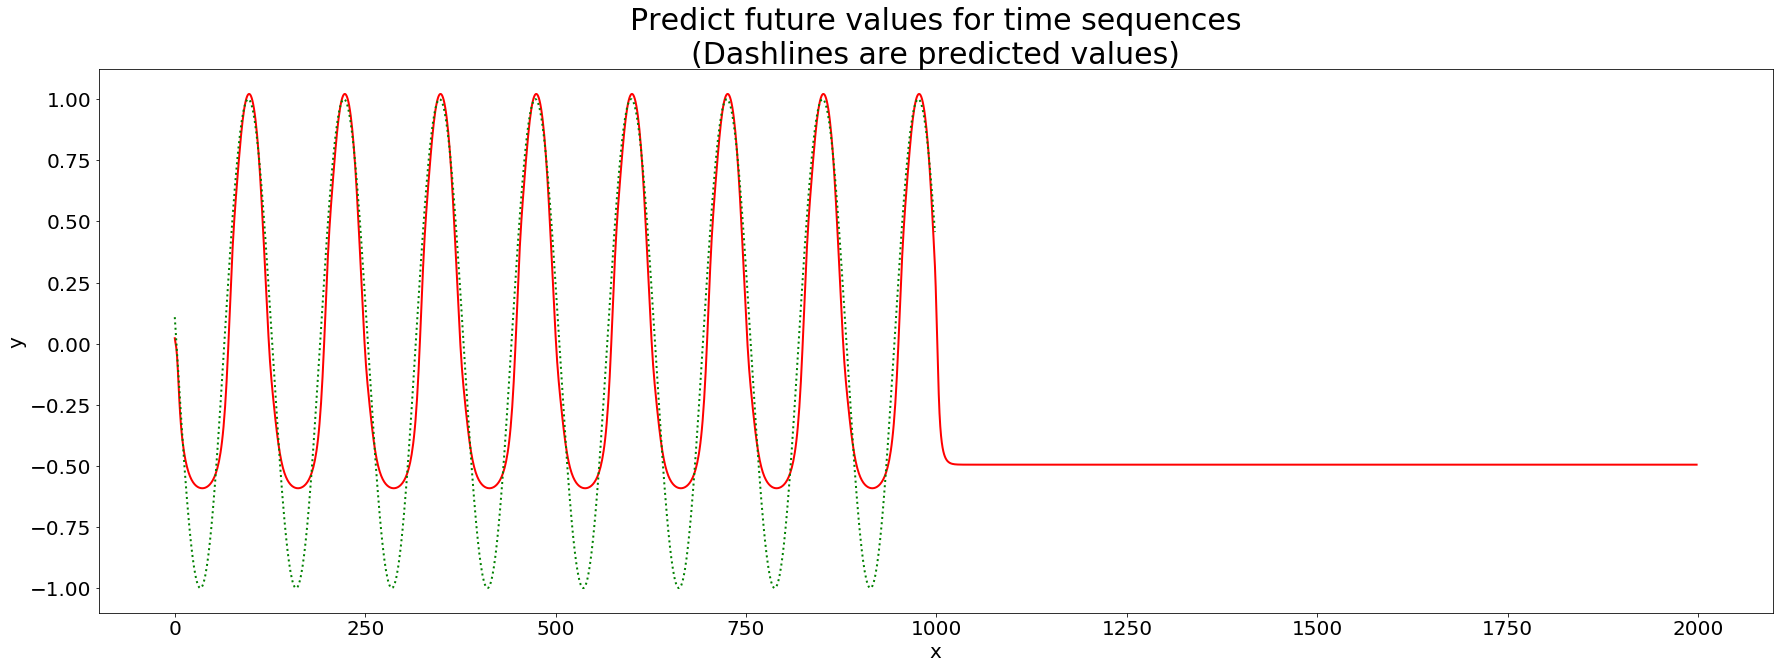

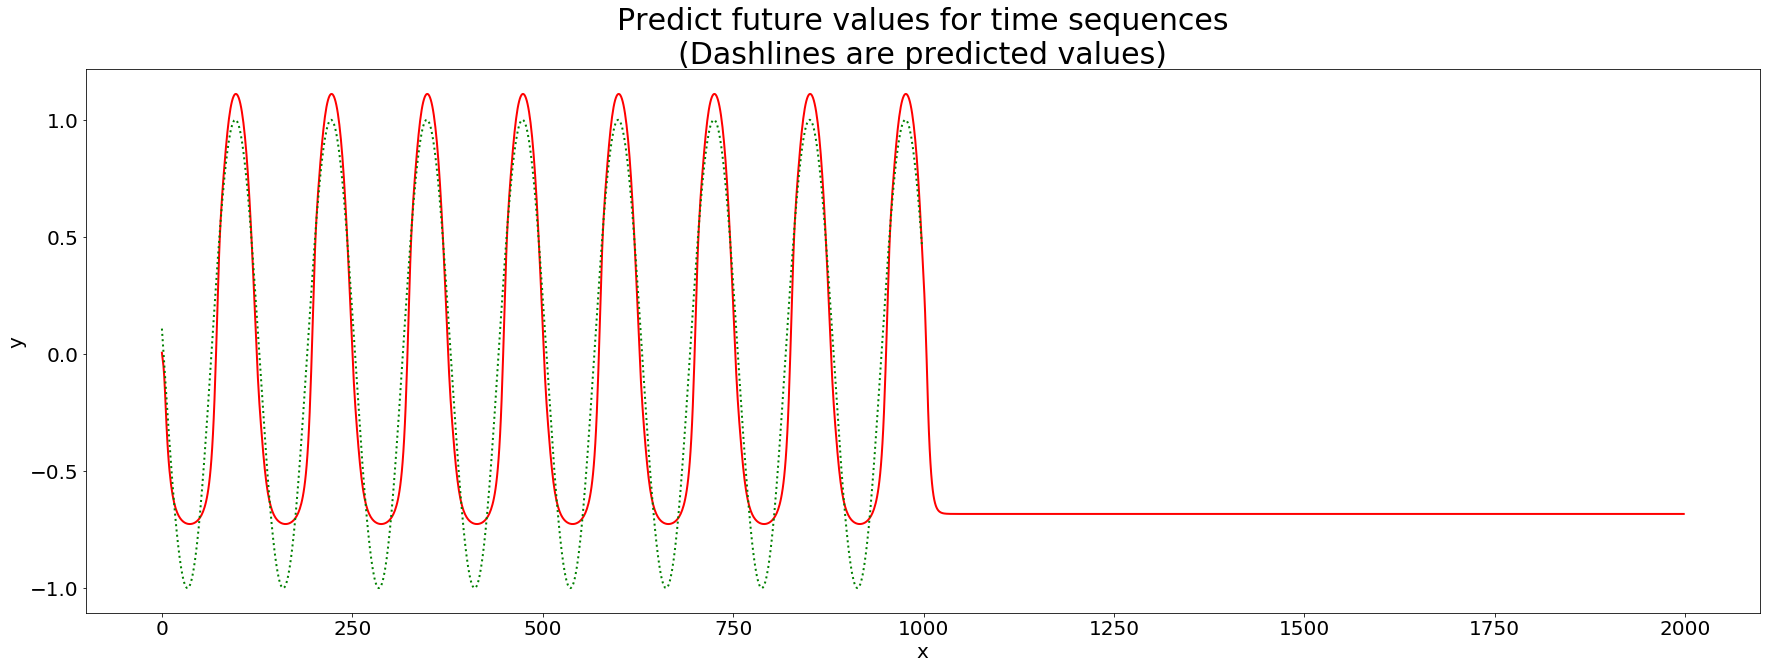

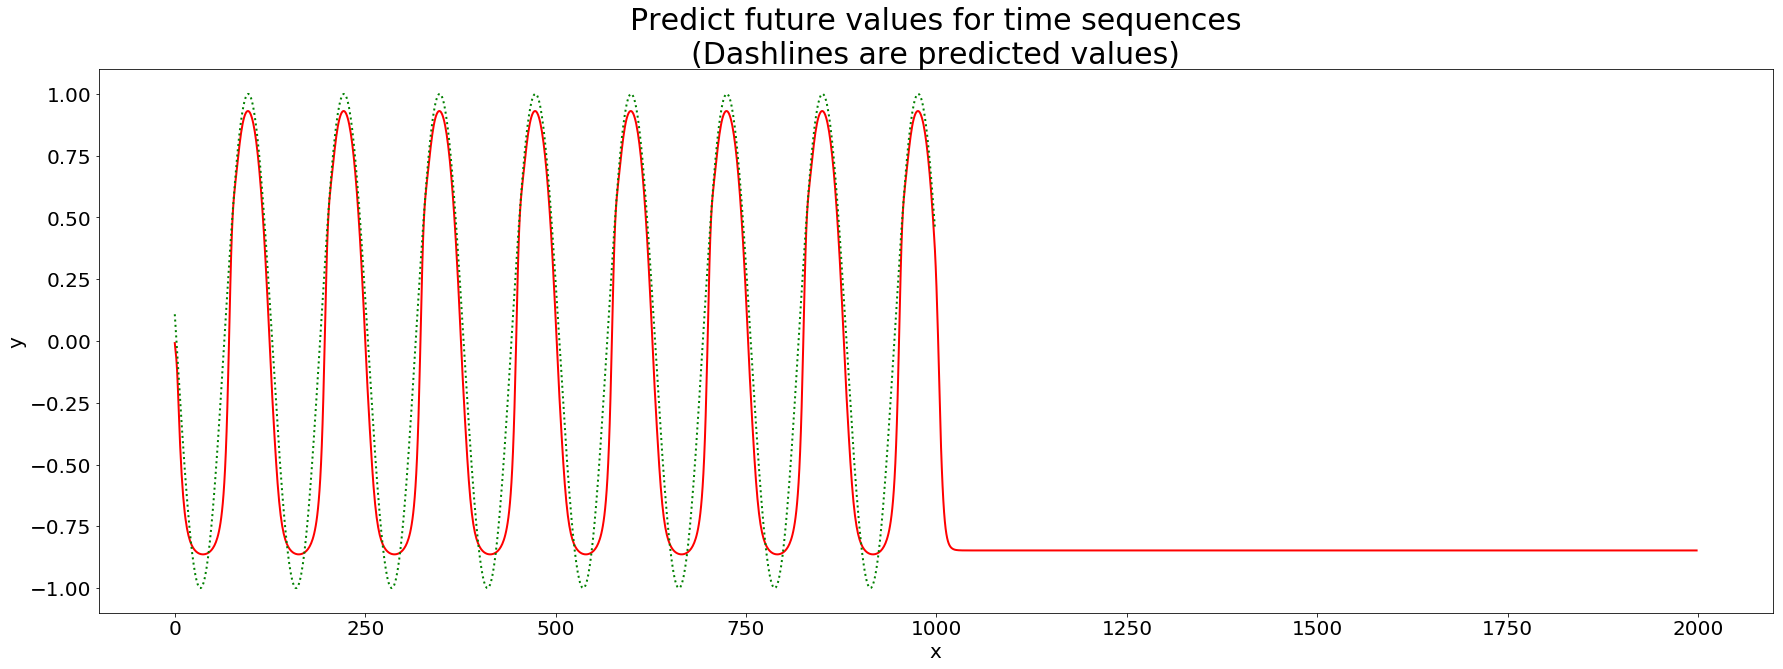

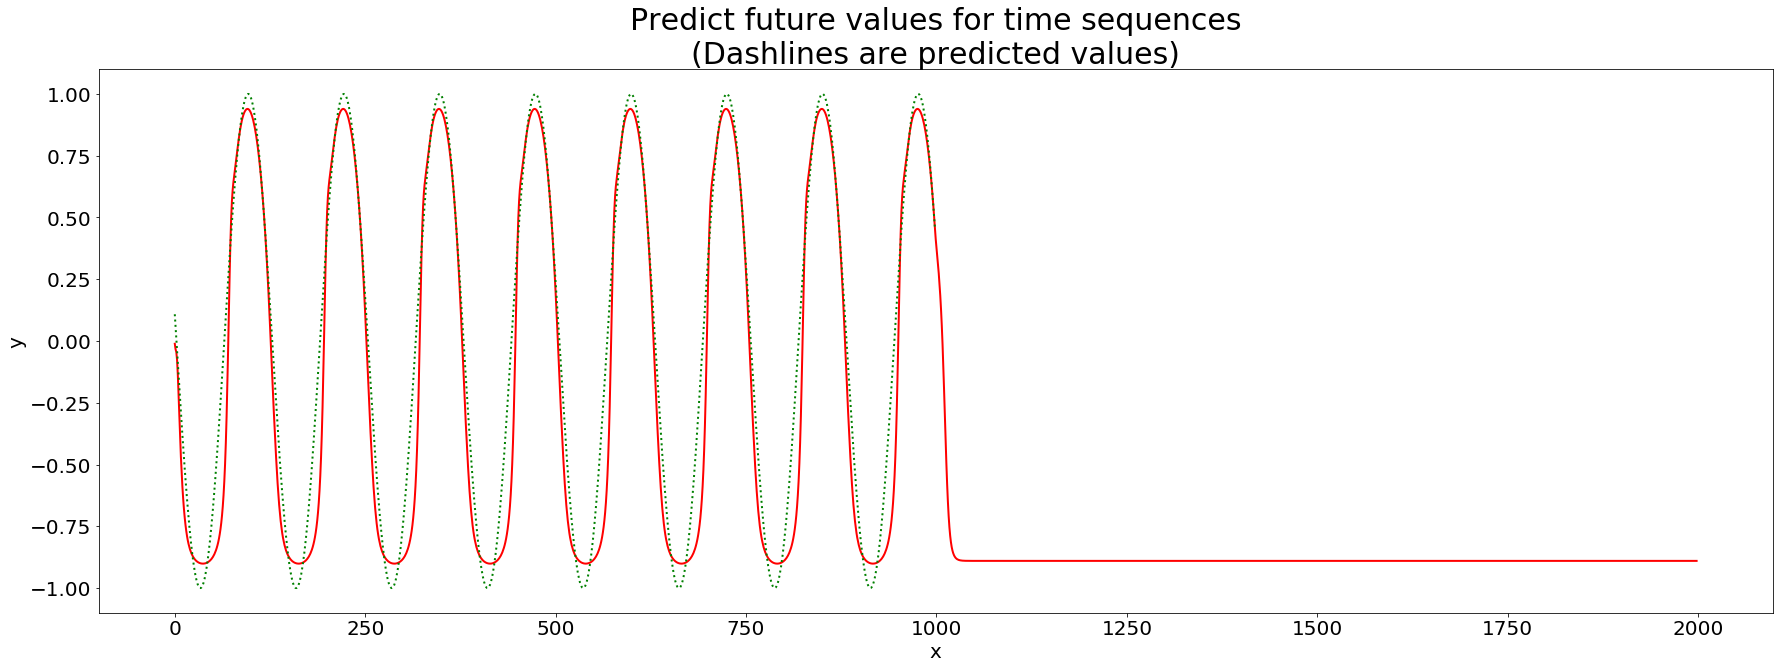

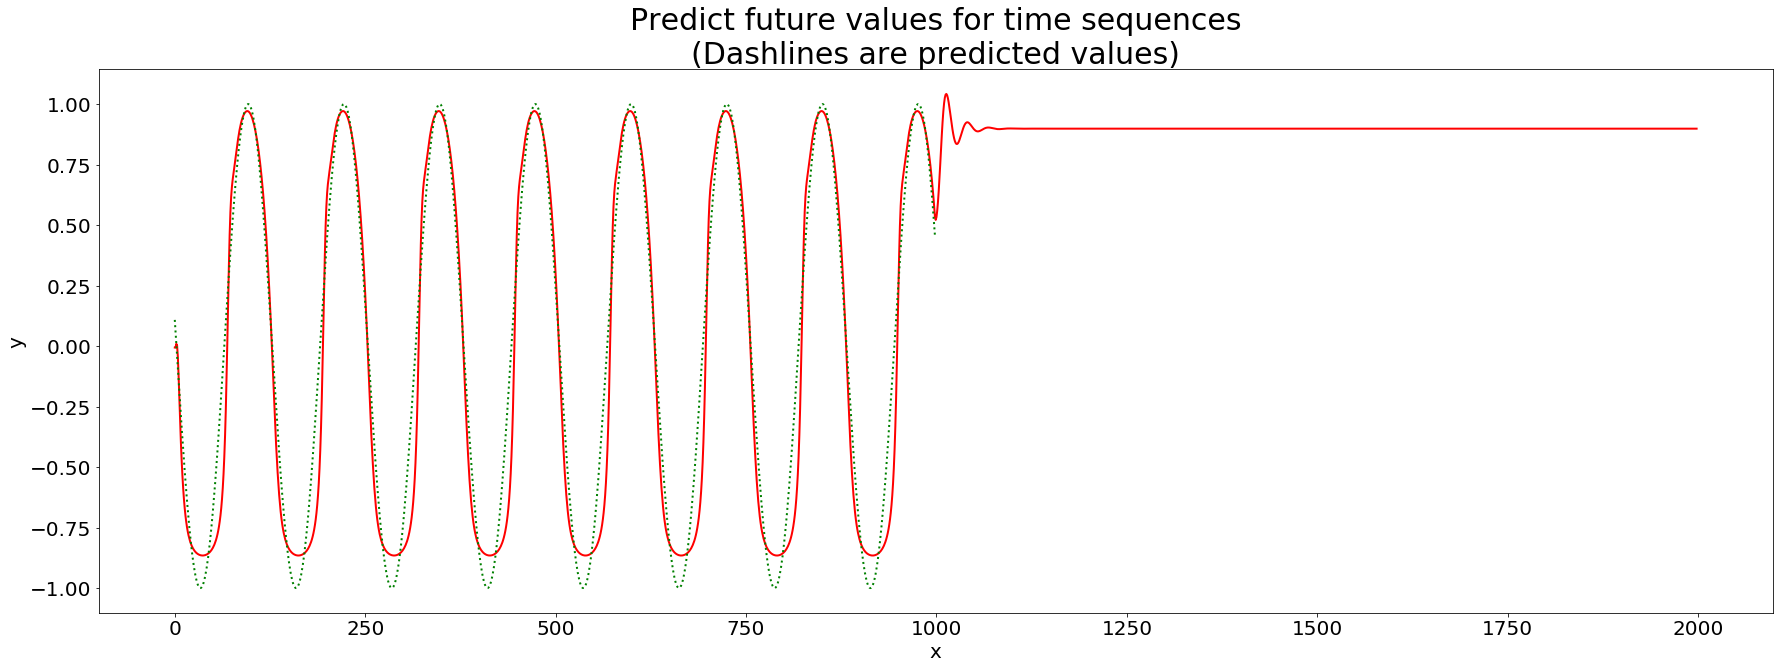

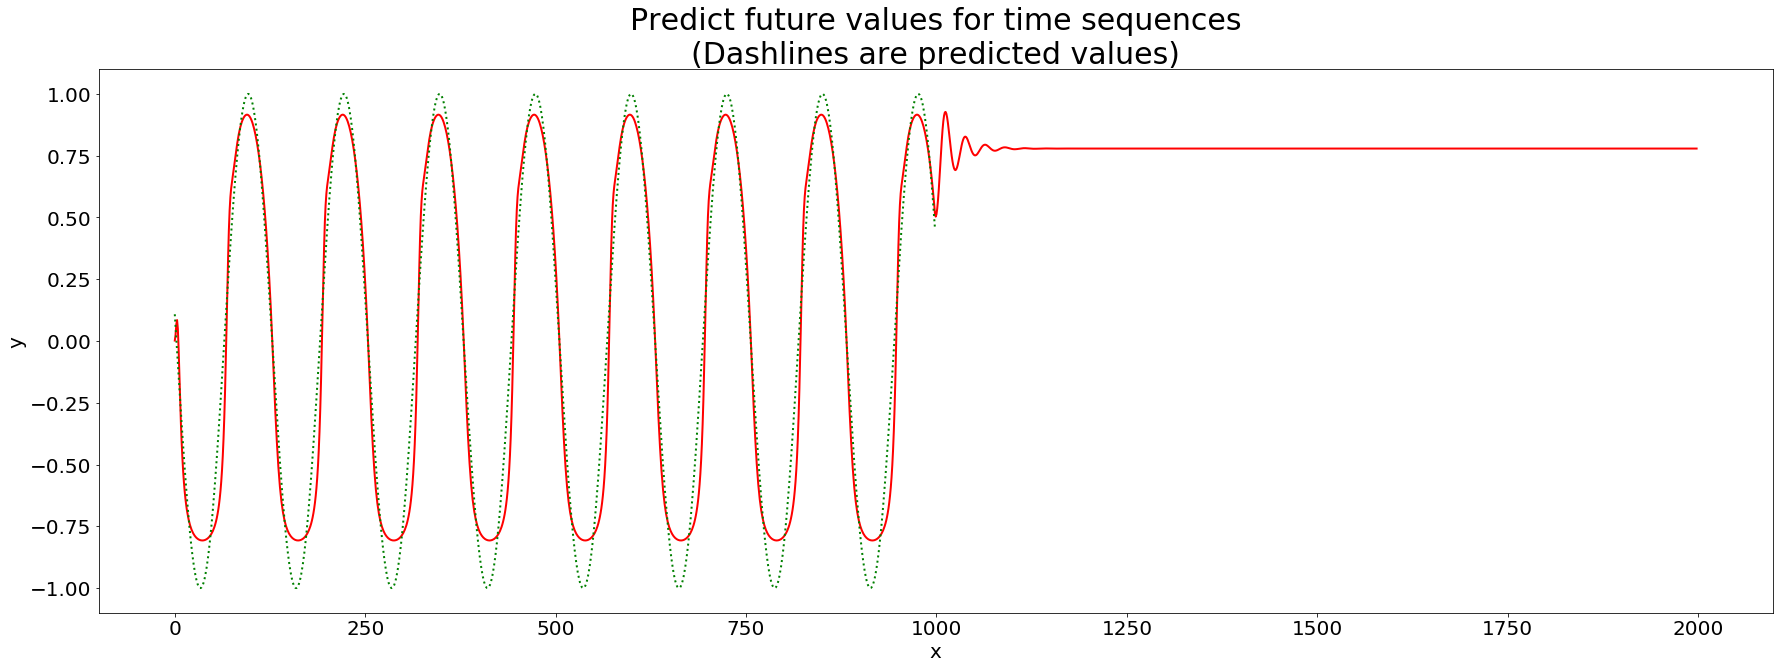

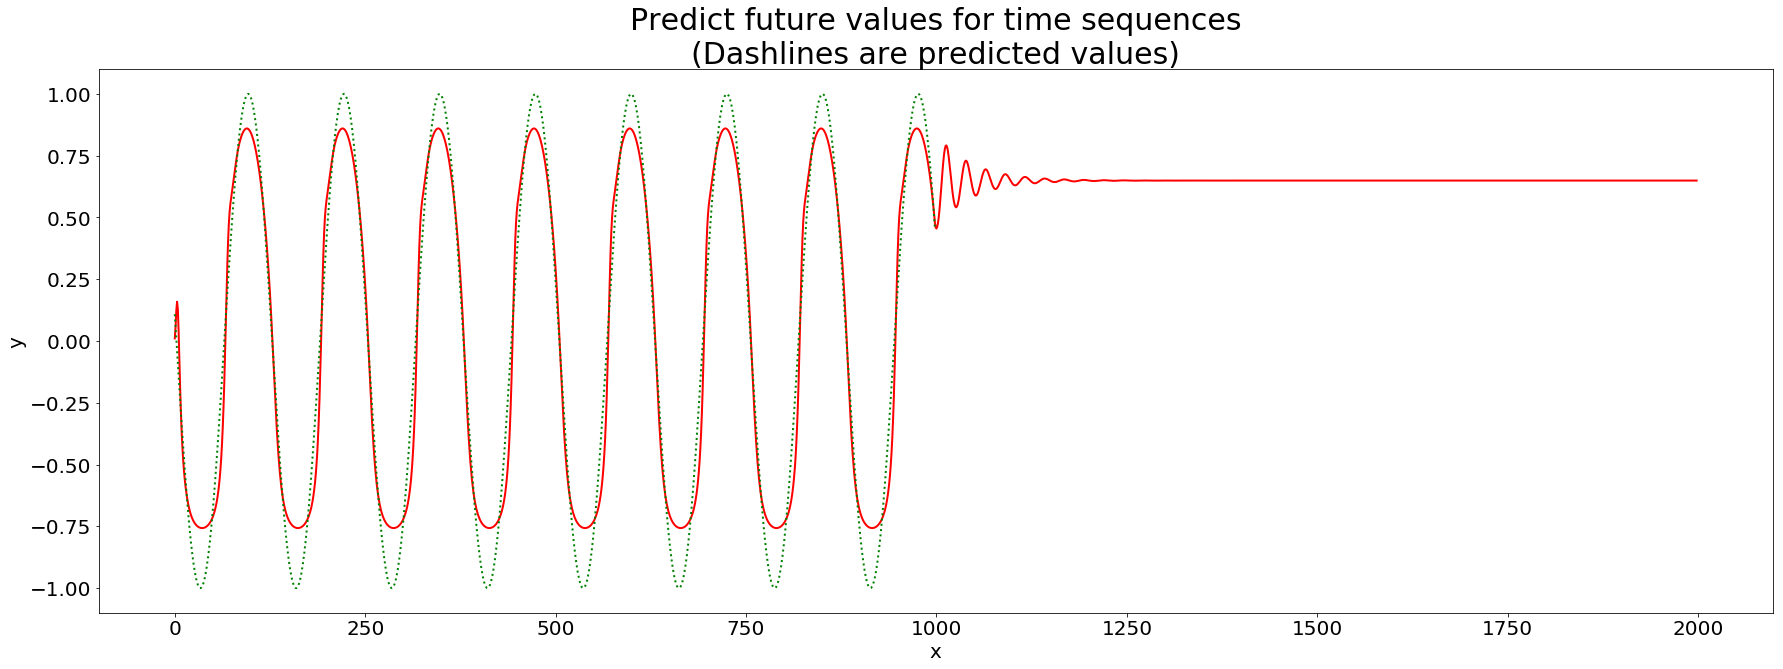

In [ ]:
if __name__ == '__main__':
    # set random seed to 0
    np.random.seed(0)
    torch.manual_seed(0)
    # load data and make training set
    data = torch.load('traindata.pt')
    data = data[0][:]
    data = np.expand_dims(data, axis=0)
    input = torch.from_numpy(data[:, :-1])
    #print(input.shape)
    target = torch.from_numpy(data[:, 1:])
    test_input = torch.from_numpy(data[:, :-1])
    print('test_input: ', test_input.shape)
    test_target = torch.from_numpy(data[:, 1:])
    # build the model
    seq = Sequence()
    seq.double()
    criterion = nn.MSELoss()
    # use LBFGS as optimizer since we can load the whole data to train
    #optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
    optimizer = torch.optim.Adam(seq.parameters(), lr=0.02)
    #begin to train
    old_state = None
    for i in range(50):
        print('STEP: ', i)
        '''def closure():
            optimizer.zero_grad()
            out = seq(input)
            loss = criterion(out, target)
            print('loss:', loss.item())
            loss.backward()
            return loss'''
        #optimizer.step(closure)
        out, h_state = seq(input, state = old_state)
        loss = criterion(out, target)         # cross entropy loss
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                         # backpropagation, compute gradients
        optimizer.step()
        h_0 = Variable(h_state[0].data)
        h_1 = Variable(h_state[1].data)
        h_2 = Variable(h_state[2].data)
        h_3 = Variable(h_state[3].data)
        #old_state = [h_0, h_1]
        old_state = [h_0, h_1, h_2, h_3]
        # begin to predict, no need to track gradient here
        with torch.no_grad():
            future = 1000
            pred, h_state = seq(test_input, future=future, state = old_state)
            loss = criterion(pred[:, :-future], test_target)
            print('test loss:', loss.item())
            y = pred.cpu().detach().numpy()
            test_input_draw = test_input.cpu().numpy()
            #print('test_input_draw: ', test_input_draw.shape)
            #print('Prediction shape: ', y.shape)
        # draw the result
        plt.figure(figsize=(30,10))
        plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
        plt.xlabel('x', fontsize=20)
        plt.ylabel('y', fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        def draw(yi, color):
            plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
            plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
        def new_draw(yi, color, shape):
            if shape == 1:
                plt.plot(np.arange(len(yi)), yi[:len(yi)], color, linewidth = 2.0)
            elif shape == 2:
                plt.plot(np.arange(len(yi)), yi[:len(yi)], color + ':', linewidth = 2.0)
        #print(len(y[0]), test_input_draw[0].shape)
        new_draw(y[0], 'r', 1)
        new_draw(test_input_draw[0], 'g', 2)
        #draw(y[2], 'b')
        #plt.savefig('predict%d.pdf'%i)
plt.close()

In [ ]:
torch.manual_seed(1)    # reproducible

In [ ]:
# Hyper Parameters
TIME_STEP = 10      # rnn time step
INPUT_SIZE = 1      # rnn input size
LR = 0.02           # learning rate

In [ ]:
# show data
steps = np.linspace(0, np.pi*2, 100, dtype=np.float32)
x_np = np.sin(steps)    # float32 for converting torch FloatTensor
y_np = np.cos(steps)
plt.plot(steps, y_np, 'r-', label='target (cos)')
plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()

In [ ]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=32,     # rnn hidden unit
            num_layers=1,       # number of rnn layer
            batch_first=True,   # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        print('x: ', x.shape)
        if h_state is not None:
            print('h: ', h_state.shape)
        r_out, h_state = self.rnn(x, h_state)
        #print(r_out.shape)
        outs = []    # save all predictions
        #print(r_out[:, 1, :].shape)
        outputs = self.out(r_out)
        for time_step in range(r_out.size(1)):    # calculate output for each time step
            outs.append(self.out(r_out[:, time_step, :]))
        return outputs, h_state

In [ ]:
rnn = RNN()
print(rnn)

In [ ]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.MSELoss()

In [ ]:
h_state = None      # for initial hidden state

In [ ]:
plt.figure(1, figsize=(12, 5))
plt.ion()           # continuously plot

x:  torch.Size([1, 10, 1])


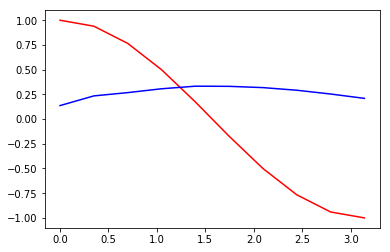

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


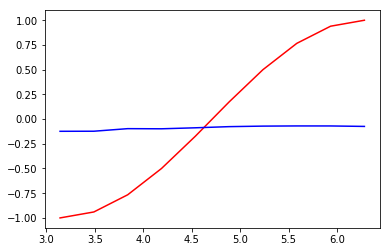

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


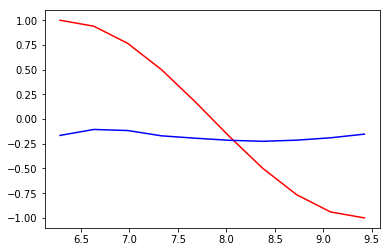

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


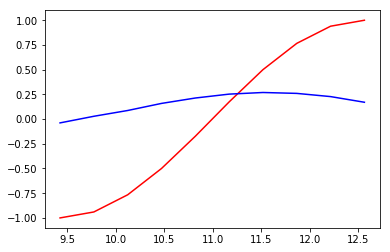

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


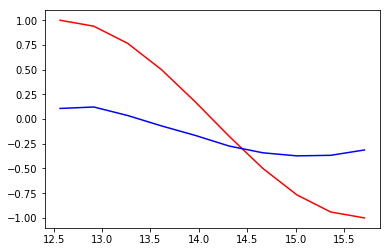

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


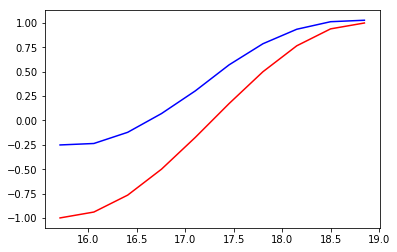

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


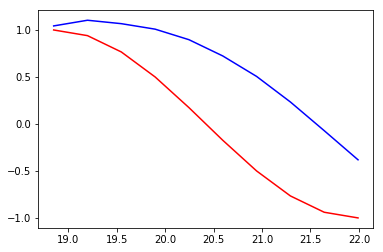

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


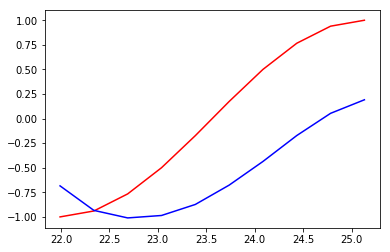

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


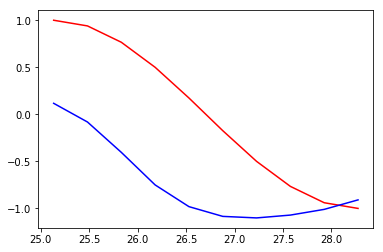

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


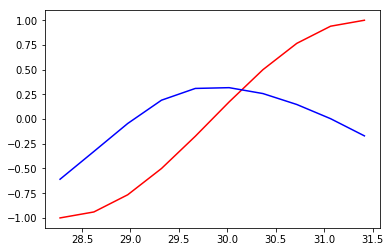

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


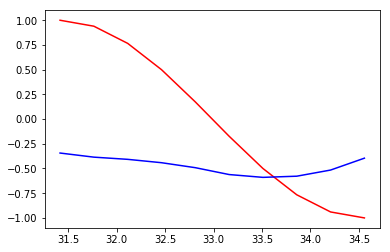

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


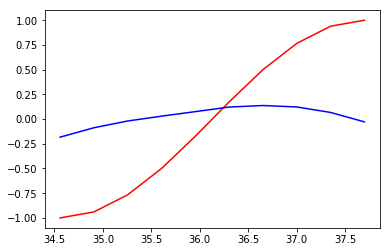

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


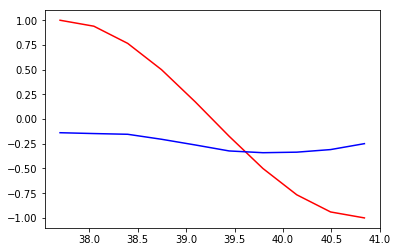

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


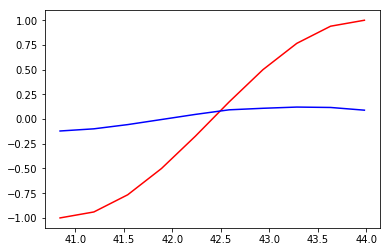

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


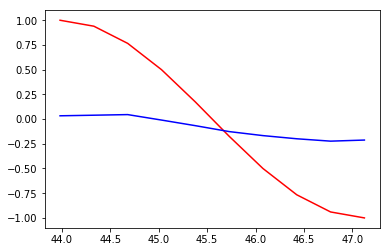

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


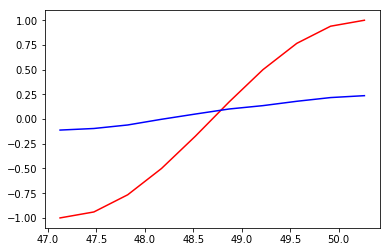

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


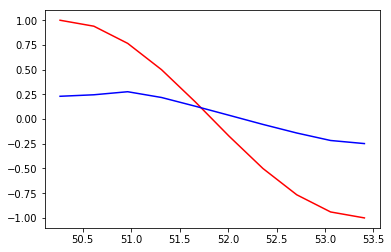

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


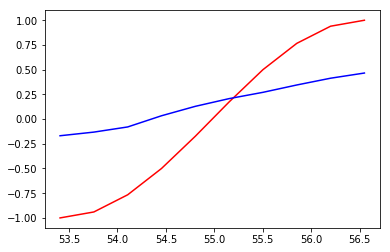

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


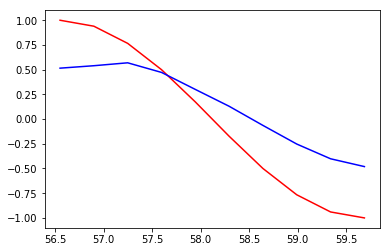

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


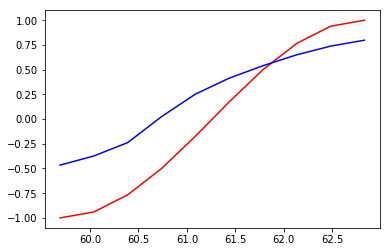

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


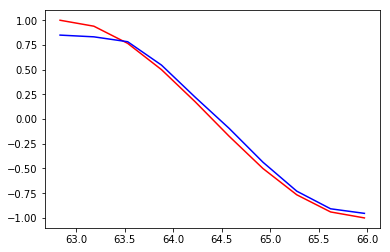

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


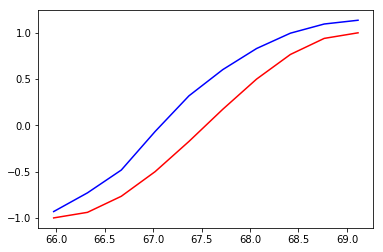

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


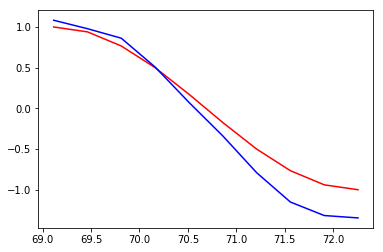

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


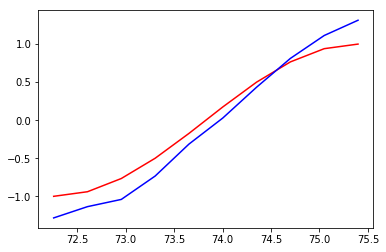

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


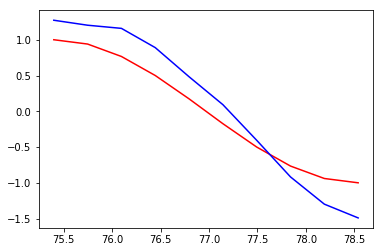

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


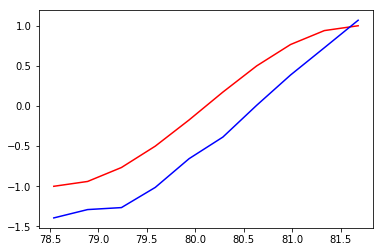

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


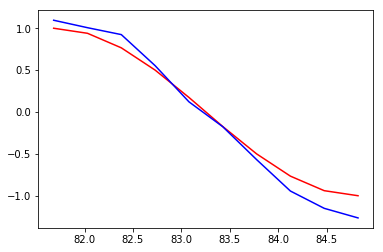

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


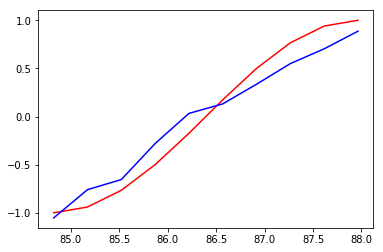

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


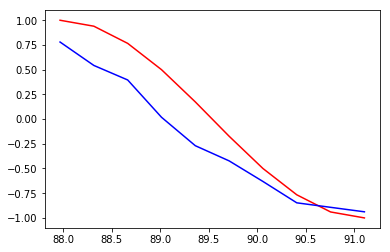

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


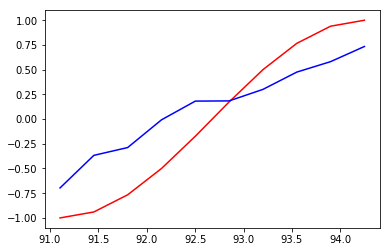

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


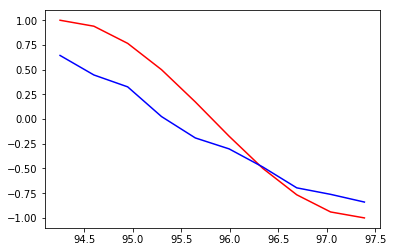

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


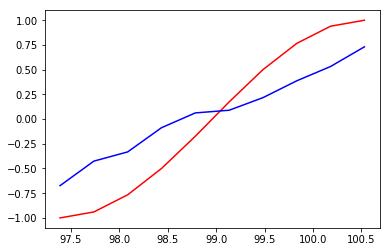

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


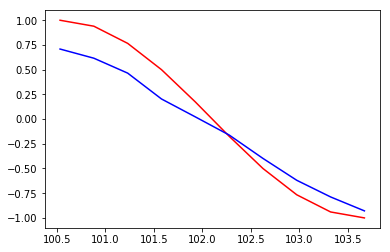

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


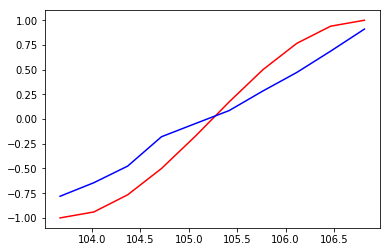

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


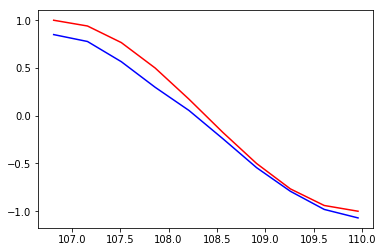

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


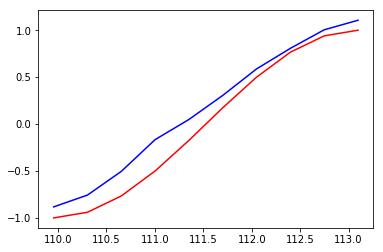

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


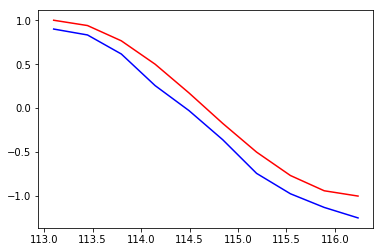

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


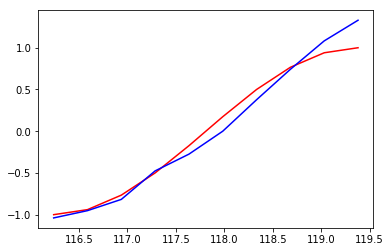

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


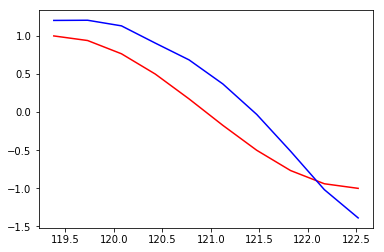

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


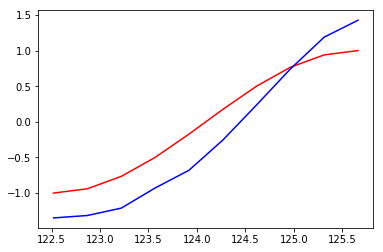

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


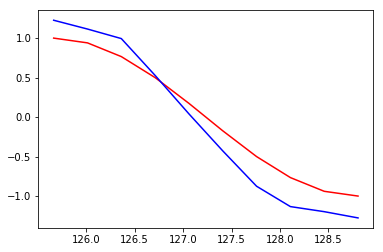

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


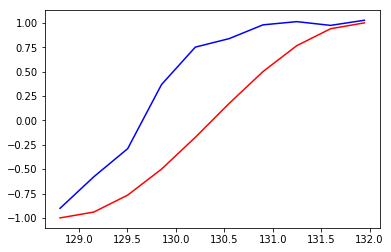

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


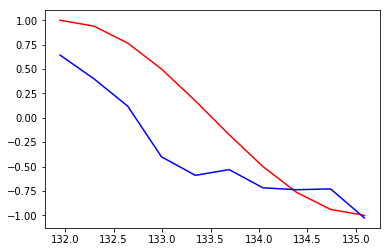

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


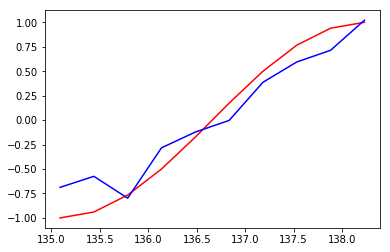

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


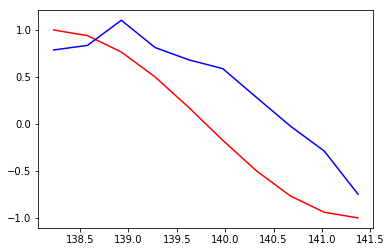

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


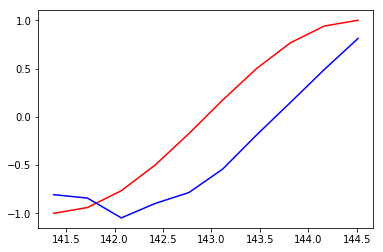

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


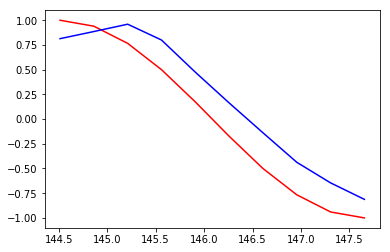

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


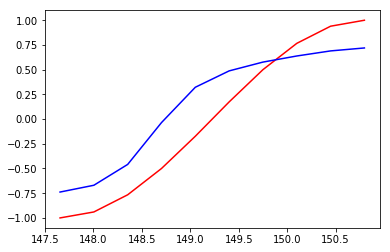

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


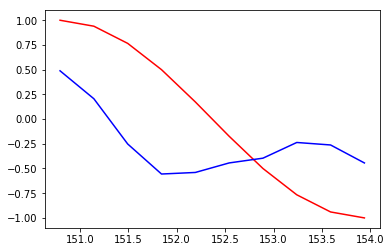

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


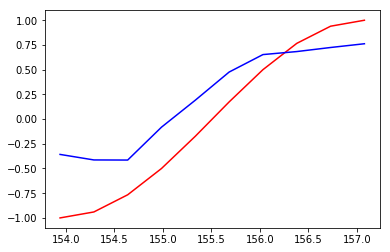

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


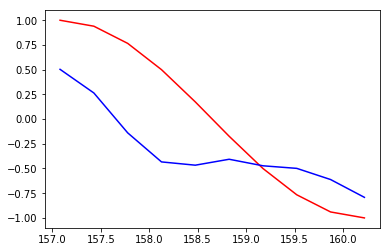

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


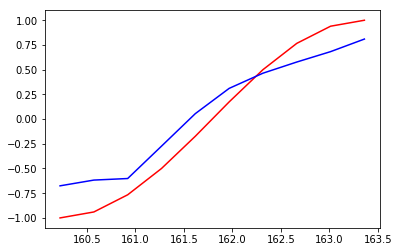

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


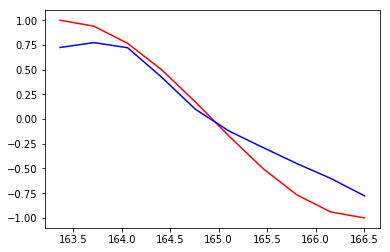

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


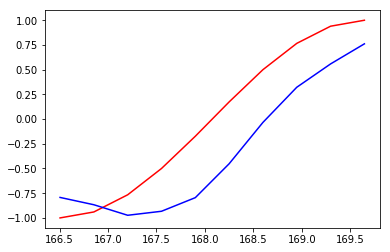

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


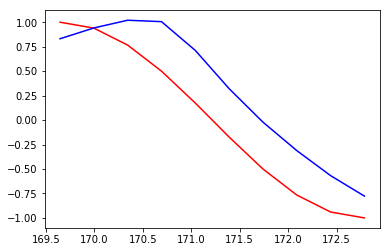

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


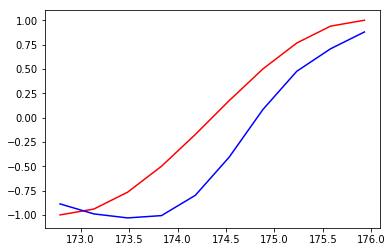

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


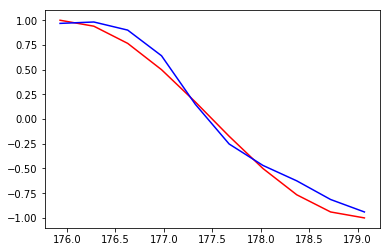

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


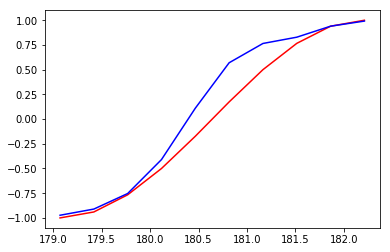

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


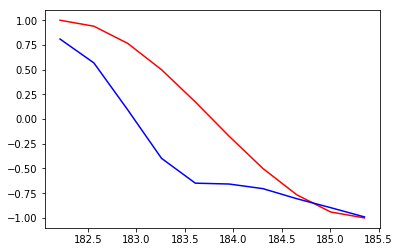

x:  torch.Size([1, 10, 1])
h:  torch.Size([1, 1, 32])


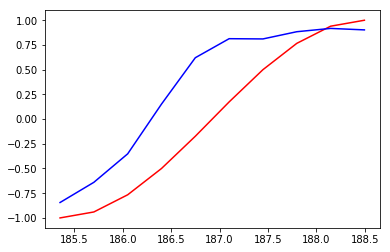

In [96]:
for step in range(60):
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np = np.sin(steps)    # float32 for converting torch FloatTensor
    y_np = np.cos(steps)

    x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis]))    # shape (batch, time_step, input_size)
    y = Variable(torch.from_numpy(y_np[np.newaxis, :, np.newaxis]))

    prediction, h_state = rnn(x, h_state)   # rnn output
    # !! next step is important !!
    h_state = Variable(h_state.data)        # repack the hidden state, break the connection from last iteration

    loss = loss_func(prediction, y)         # cross entropy loss
    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients

    # plotting
    plt.plot(steps, y_np.flatten(), 'r-')
    plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
    plt.draw(); plt.pause(0.05)